In [1]:
import torch
import json
import ast
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt

def process_punct(row):
    rem_sym = [',', '.', '!', '?']
    for p in rem_sym:
        row = row.replace(p, '')
    return row

def hard_processing(text):
    text = re.sub(r"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def comp_metric(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p,  = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([hard_processing(s) for s in y_true_sample])
        y_pred_sample = set([hard_processing(s) for s in y_pred_sample])

        tp += len(y_true_sample & y_pred_sample)
        fp += len(y_pred_sample - y_true_sample)
        fn += len(y_true_sample - y_pred_sample)
        p += len(y_true_sample)

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)

    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    return round(f1, 8)

BASE_PATH = 'nlp_data'
MAX_LEN = 16
TRAIN_BATCH_SIZE = 5
VAL_BATCH_SIZE = 5
EPOCHS = 3
start = time.time()
df_r = pd.read_csv(f'{BASE_PATH}/uk_geo_dataset.csv')
data_r = df_r[['text', 'loc_markers']].iloc[:10000, :]

tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = BertForTokenClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=3)

data_r['prep_text'] = data_r['text'].apply(process_punct)

tokenized_r = tokenizer(data_r['prep_text'].tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LEN)

# raise ConnectionAbortedError
tokens = []
bio_labels = []
for ids in tokenized_r['input_ids']:
    decoded = tokenizer.decode(ids.tolist(), skip_special_tokens=True)
    tokens.append(decoded.split())
    bio_labels.append(['O'] * len(decoded.split()))


for sample_idx, sample in enumerate(data_r['loc_markers'].tolist()):
    locations = ast.literal_eval(sample)
    for loc_idx, loc in enumerate(locations):
        loc_text = data_r['text'].tolist()[sample_idx][loc[0]:loc[1]]
        words_in_loc_text = loc_text.count(' ')
        if words_in_loc_text > 0:
            indexes = [(i, i + words_in_loc_text) for i in range(len(tokens[sample_idx])-words_in_loc_text) if ' '.join([tokens[sample_idx][i+j] for j in range(words_in_loc_text + 1)])  == loc_text]
        else:
            indexes = [i for i, token in enumerate(tokens[sample_idx]) if token == loc_text]

        for index in indexes:
            if isinstance(index, int):
                bio_labels[sample_idx][index] = 'B-LOC'
            else:
                for inner_idx in range(index[0], index[1]+1):
                    if inner_idx == index[0]:
                        bio_labels[sample_idx][inner_idx] = 'B-LOC'
                    else:
                        bio_labels[sample_idx][inner_idx] = 'I-LOC'

label2id = {'O': 0, 'B-LOC': 1, 'I-LOC': 2}
converted = []
for sample in bio_labels:
    temp = []
    for label in sample:
        temp.append(label2id[label])
    converted.append(temp)
data_r['prep_labels'] = converted
# print(data_r.head(5))

class NERDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        # self.orig_tokens = orig_tokens

    def __len__(self):
        return len(self.texts['input_ids'])

    def __getitem__(self, idx):
        # print(self.texts['input_ids'].shape)
        # print(self.texts['attention_mask'].shape)
        # raise ConnectionAbortedError
        input_ids = self.texts['input_ids'][idx]
        attention = self.texts['attention_mask'][idx]
        labels_init = self.labels.tolist()[idx]
        labels_init.insert(0, 0)
        if  MAX_LEN - len(labels_init) >= 0:
            labels = np.pad(labels_init, (0, MAX_LEN - len(labels_init)), constant_values=0)
        else:
            labels = labels_init[:MAX_LEN]
        # tokens = self.get_orig_tokens(idx)
        # tokens = np.pad(tokens, (0, MAX_LEN - len(tokens)), constant_values='')
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention,
            'labels': torch.tensor(labels, dtype=torch.long)
        }
    
    # def get_orig_tokens(self, idx):
    #     return self.orig_tokens[idx]


# for idx, sample in enumerate(data_r['prep_labels'].tolist()):
#     ones = sample.count(1)
#     if (ones / len(sample)) > 0.1:
#         indexes.append(idx)
    
# texts_train = np.array(data_r['prep_text'].tolist())[indexes]
# # print(len(texts_train))
# labels_train = data_r['prep_labels'].to_numpy()[indexes]
# print(texts_train.tolist()[0])
# print(labels_train.tolist()[0])
# print(len(labels_train))

texts_train, texts_val, labels_train, labels_val = train_test_split(
    data_r['prep_text'], data_r['prep_labels'], test_size=0.2, random_state=123
)
train_tokens = []
val_tokens = []
train_t = tokenizer(texts_train.tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LEN)
val_t = tokenizer(texts_val.tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LEN)
indexes = []


# plt.figure()
# sns.histplot(length)
# plt.show()
# raise ConnectionAbortedError
# for ids in train_t['input_ids']:
#     decoded = tokenizer.decode(ids.tolist(), skip_special_tokens=True)
#     train_tokens.append(decoded.split())

# for ids in val_t['input_ids']:
#     decoded = tokenizer.decode(ids.tolist(), skip_special_tokens=True)
#     val_tokens.append(decoded.split())


train_dataset = NERDataset(tokenizer(texts_train.tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LEN).to('cuda'), labels_train)
val_dataset = NERDataset(tokenizer(texts_val.tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LEN).to('cuda'), labels_val)
# print(len(train_dataset))
# raise ConnectionAbortedError
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)

# Set up optimizer and scheduler
optimizer = AdamW([
    {'params': list(model.bert.parameters()), 'lr': 1e-6},
    {'params': list(model.classifier.parameters()), 'lr': 1e-3}
])

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = torch.nn.CrossEntropyLoss(torch.tensor([1.0, 200.0, 200.0]).to('cuda'))
model.to('cuda')
fin = time.time()
# print(fin - start)
# raise ConnectionAbortedError



Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2023-12-17 18:07:33.308427: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 18:07:33.328622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 18:07:33.659006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] 

100%|██████████| 1600/1600 [00:37<00:00, 42.30it/s]


Train loss: 0.3614252527474309, train f1: 0.3449687775499992


100%|██████████| 400/400 [00:03<00:00, 131.88it/s]


Val loss: 0.22079482422210275, val f1: 0.42912832739999973


100%|██████████| 1600/1600 [00:37<00:00, 42.55it/s]


Train loss: 0.20971826421298828, train f1: 0.477009055018749


100%|██████████| 400/400 [00:03<00:00, 131.75it/s]


Val loss: 0.20526796954844032, val f1: 0.4725094803249994


100%|██████████| 1600/1600 [00:37<00:00, 42.54it/s]


Train loss: 0.18518175569059622, train f1: 0.5095517807187495


100%|██████████| 400/400 [00:03<00:00, 131.85it/s]


Val loss: 0.17842057636669778, val f1: 0.6062060561249992


100%|██████████| 1600/1600 [00:37<00:00, 42.53it/s]


Train loss: 0.17308550668029737, train f1: 0.5140740891875006


100%|██████████| 400/400 [00:03<00:00, 131.99it/s]


Val loss: 0.1951554329870669, val f1: 0.6319039224499995


100%|██████████| 1600/1600 [00:37<00:00, 42.53it/s]


Train loss: 0.16027738150945425, train f1: 0.5343830191562504


100%|██████████| 400/400 [00:03<00:00, 132.12it/s]


Val loss: 0.19119248398978017, val f1: 0.5578683676749998


100%|██████████| 1600/1600 [00:37<00:00, 42.52it/s]


Train loss: 0.15405812553641796, train f1: 0.5238913903062506


100%|██████████| 400/400 [00:03<00:00, 132.15it/s]


Val loss: 0.19561598965379745, val f1: 0.6227777291749996


100%|██████████| 1600/1600 [00:37<00:00, 42.53it/s]


Train loss: 0.14283716420149745, train f1: 0.5677042774062505


100%|██████████| 400/400 [00:03<00:00, 132.14it/s]


Val loss: 0.1879404117200329, val f1: 0.5624845937999999


100%|██████████| 1600/1600 [00:37<00:00, 42.55it/s]


Train loss: 0.1397865358724401, train f1: 0.5820915709500002


100%|██████████| 400/400 [00:03<00:00, 131.45it/s]


Val loss: 0.1769810151466868, val f1: 0.643010101


100%|██████████| 1600/1600 [00:37<00:00, 42.55it/s]


Train loss: 0.11894236005834571, train f1: 0.66058101498125


100%|██████████| 400/400 [00:03<00:00, 131.43it/s]


Val loss: 0.15259496808269432, val f1: 0.7


100%|██████████| 1600/1600 [00:37<00:00, 42.54it/s]


Train loss: 0.10917165864554423, train f1: 0.7588750000000001


100%|██████████| 400/400 [00:03<00:00, 132.59it/s]


Val loss: 0.1557541250292924, val f1: 0.9125


100%|██████████| 1600/1600 [00:37<00:00, 42.57it/s]


Train loss: 0.08783257931764701, train f1: 0.906875


100%|██████████| 400/400 [00:02<00:00, 133.36it/s]


Val loss: 0.15388354095417658, val f1: 0.9775


100%|██████████| 1600/1600 [00:37<00:00, 42.55it/s]


Train loss: 0.07741178875818418, train f1: 0.969375


100%|██████████| 400/400 [00:03<00:00, 133.17it/s]


Val loss: 0.09712411464386872, val f1: 0.9825


100%|██████████| 1600/1600 [00:37<00:00, 42.56it/s]


Train loss: 0.05078748152957461, train f1: 0.99


100%|██████████| 400/400 [00:02<00:00, 133.48it/s]


Val loss: 0.06252383447415509, val f1: 0.9975


100%|██████████| 1600/1600 [00:37<00:00, 42.57it/s]


Train loss: 0.021787981112444014, train f1: 1.0


100%|██████████| 400/400 [00:02<00:00, 133.44it/s]


Val loss: 0.01939912918963662, val f1: 1.0


100%|██████████| 1600/1600 [00:37<00:00, 42.56it/s]


Train loss: 0.008199071604528518, train f1: 0.999375


100%|██████████| 400/400 [00:03<00:00, 133.11it/s]


Val loss: 0.0046494829210694845, val f1: 1.0


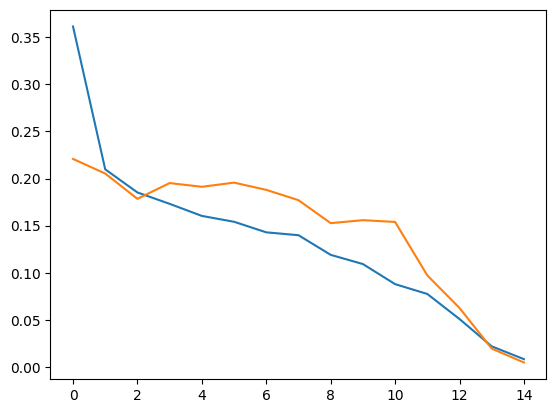

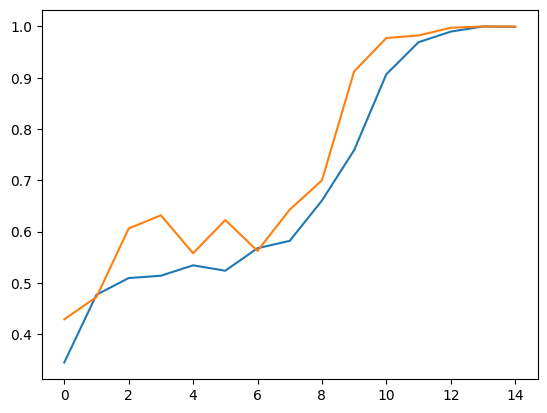

In [2]:
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
EPOCHS = 15
train_loss = []
val_loss = []
train_f1 = []
val_f1 = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_f1 = 0
    counter =0
    for batch in tqdm(train_dataloader):
        
        inputs = {key: value.to('cuda') for key, value in batch.items() if (key != 'labels' and key != 'tokens')}
        outputs = model(**inputs)
        
        probs = torch.nn.functional.softmax(outputs.logits, dim=2)
        
        coded_pred = torch.argmax(probs, dim=2)

        loss = criterion(outputs.logits.view(-1, 3), batch['labels'].to('cuda').view(-1))
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        tokens_batched = []
        
        for ids in batch['input_ids']:
            decoded = tokenizer.decode(ids.tolist(), skip_special_tokens=True)
            tokens_batched.append(decoded.split())

        # print(coded_pred.shape)
        # print(batch['labels'].shape)
        # raise ConnectionAbortedError
    
        tokens_gt_batched = []
        for batch_idx, sample in enumerate(batch['labels']):
            sample_gt = []
            for idx, class_t in enumerate(sample[1:len(tokens_batched[batch_idx])+1]):
                if class_t != 0:
                    sample_gt.append(tokens_batched[batch_idx][idx])
            tokens_gt_batched.append(sample_gt)
        
        tokens_pred_batched = []
        for batch_idx, sample in enumerate(coded_pred):
            sample_pred = []
            for idx, class_t in enumerate(sample[1:len(tokens_batched[batch_idx])+1]):
                if class_t != 0:
                    sample_pred.append(tokens_batched[batch_idx][idx])
            tokens_pred_batched.append(sample_pred)

        # for batch_num in range(TRAIN_BATCH_SIZE):
        #     max_num_tok = len(tokens_gt_batched[batch_num])
        #     if len(tokens_pred_batched[batch_num]) > max_num_tok:
        #         for _ in range(len(tokens_pred_batched[batch_num]) - max_num_tok):
        #             tokens_gt_batched[batch_num].append('')
        #     else:
        #         for _ in range(max_num_tok - len(tokens_pred_batched[batch_num])):
        #             tokens_pred_batched[batch_num].append('')
        
        
        f1 = comp_metric(tokens_gt_batched, tokens_pred_batched)
        total_f1 += f1

        optimizer.step()
        # if counter % 100 == 0:
        # print(f'F1: {f1}, loss: {loss}')
        # counter += 1
        # if counter == 10:
        #     raise ConnectionAbortedError
        # scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_f1 = total_f1 / len(train_dataloader)
    train_loss.append(avg_train_loss)
    train_f1.append(avg_train_f1)
    print(f"Train loss: {avg_train_loss}, train f1: {avg_train_f1}")
    
    model.eval()
    total_val_loss = 0
    total_val_f1 = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs = {key: value.to('cuda') for key, value in batch.items() if key != 'labels'}
            outputs = model(**inputs, labels=batch['labels'].to('cuda'))

            probs = torch.nn.functional.softmax(outputs.logits, dim=2)
        
            coded_pred = torch.argmax(probs, dim=2)
            torch.nn.utils.clip_grad_value_(model.parameters(), 10)
            loss = criterion(outputs.logits.view(-1, 3), batch['labels'].to('cuda').view(-1))
            total_val_loss += loss.item()

            tokens_batched = []
            
            for ids in batch['input_ids']:
                decoded = tokenizer.decode(ids.tolist(), skip_special_tokens=True)
                tokens_batched.append(decoded.split())

            tokens_gt_batched = []
            for batch_idx, sample in enumerate(batch['labels']):
                sample_gt = []
                for idx, class_t in enumerate(sample[1:len(tokens_batched[batch_idx])+1]):
                    if class_t != 0:
                        sample_gt.append(tokens_batched[batch_idx][idx])
                tokens_gt_batched.append(sample_gt)
            
            tokens_pred_batched = []
            for batch_idx, sample in enumerate(coded_pred):
                sample_pred = []
                for idx, class_t in enumerate(sample[1:len(tokens_batched[batch_idx])+1]):
                    if class_t != 0:
                        sample_pred.append(tokens_batched[batch_idx][idx])
                tokens_pred_batched.append(sample_pred)

            # for batch_num in range(TRAIN_BATCH_SIZE):
            #     max_num_tok = len(tokens_gt_batched[batch_num])
            #     if len(tokens_pred_batched[batch_num]) > max_num_tok:
            #         for _ in range(len(tokens_pred_batched[batch_num]) - max_num_tok):
            #             tokens_gt_batched[batch_num].append('')
            #     else:
            #         for _ in range(max_num_tok - len(tokens_pred_batched[batch_num])):
            #             tokens_pred_batched[batch_num].append('')
            
            
            f1 = comp_metric(tokens_gt_batched, tokens_pred_batched)
            total_val_f1 += f1

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_f1 = total_val_f1 / len(val_dataloader)
    val_loss.append(avg_val_loss)
    val_f1.append(avg_val_f1)
    print(f"Val loss: {avg_val_loss}, val f1: {avg_val_f1}")
    
plt.figure()
sns.lineplot(train_loss)
sns.lineplot(val_loss)
plt.savefig('Losses_ukr.png')

plt.figure()
sns.lineplot(train_f1)
sns.lineplot(val_f1)
plt.savefig('f1_ukr.png')

torch.save(model, 'uk_300k_last.pth')
torch.save(model.state_dict(), 'uk_weights_300k_last.pth')
torch.save(tokenizer, 'uk_tokenizer_300k_last.pth')

In [16]:
import torch
import json
import ast
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt

def process_punct(row):
    rem_sym = [',', '.', '!', '?']
    for p in rem_sym:
        row = row.replace(p, '')
    return row

def hard_processing(text):
    text = re.sub(r"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\b\w\b\s?', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def comp_metric(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p,  = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        y_true_sample = set([hard_processing(s) for s in y_true_sample])
        y_pred_sample = set([hard_processing(s) for s in y_pred_sample])

        tp += len(y_true_sample & y_pred_sample)
        fp += len(y_pred_sample - y_true_sample)
        fn += len(y_true_sample - y_pred_sample)
        p += len(y_true_sample)

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)

    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    return round(f1, 8)

BASE_PATH = 'nlp_data'
MAX_LEN = 16

start = time.time()
df_r = pd.read_csv(f'{BASE_PATH}/ru_geo_dataset.csv')
data_r = df_r[['text', 'loc_markers']].iloc[:10000, :]

tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = BertForTokenClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=3)

data_r['prep_text'] = data_r['text'].apply(process_punct)

tokenized_r = tokenizer(data_r['prep_text'].tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LEN)

# raise ConnectionAbortedError
tokens = []
bio_labels = []
for ids in tokenized_r['input_ids']:
    decoded = tokenizer.decode(ids.tolist(), skip_special_tokens=True)
    tokens.append(decoded.split())
    bio_labels.append(['O'] * len(decoded.split()))


for sample_idx, sample in enumerate(data_r['loc_markers'].tolist()):
    locations = ast.literal_eval(sample)
    for loc_idx, loc in enumerate(locations):
        loc_text = data_r['text'].tolist()[sample_idx][loc[0]:loc[1]]
        words_in_loc_text = loc_text.count(' ')
        if words_in_loc_text > 0:
            indexes = [(i, i + words_in_loc_text) for i in range(len(tokens[sample_idx])-words_in_loc_text) if ' '.join([tokens[sample_idx][i+j] for j in range(words_in_loc_text + 1)])  == loc_text]
        else:
            indexes = [i for i, token in enumerate(tokens[sample_idx]) if token == loc_text]

        for index in indexes:
            if isinstance(index, int):
                bio_labels[sample_idx][index] = 'B-LOC'
            else:
                for inner_idx in range(index[0], index[1]+1):
                    if inner_idx == index[0]:
                        bio_labels[sample_idx][inner_idx] = 'B-LOC'
                    else:
                        bio_labels[sample_idx][inner_idx] = 'I-LOC'

label2id = {'O': 0, 'B-LOC': 1, 'I-LOC': 2}
converted = []
for sample in bio_labels:
    temp = []
    for label in sample:
        temp.append(label2id[label])
    converted.append(temp)
data_r['prep_labels'] = converted
# print(data_r.head(5))

class NERDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        # self.orig_tokens = orig_tokens

    def __len__(self):
        return len(self.texts['input_ids'])

    def __getitem__(self, idx):
        # print(self.texts['input_ids'].shape)
        # print(self.texts['attention_mask'].shape)
        # raise ConnectionAbortedError
        input_ids = self.texts['input_ids'][idx]
        attention = self.texts['attention_mask'][idx]
        labels_init = self.labels.tolist()[idx]
        labels_init.insert(0, 0)
        if  MAX_LEN - len(labels_init) >= 0:
            labels = np.pad(labels_init, (0, MAX_LEN - len(labels_init)), constant_values=0)
        else:
            labels = labels_init[:MAX_LEN]
        # tokens = self.get_orig_tokens(idx)
        # tokens = np.pad(tokens, (0, MAX_LEN - len(tokens)), constant_values='')
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention,
            'labels': torch.tensor(labels, dtype=torch.long)
        }
    
    # def get_orig_tokens(self, idx):
    #     return self.orig_tokens[idx]


# for idx, sample in enumerate(data_r['prep_labels'].tolist()):
#     ones = sample.count(1)
#     if (ones / len(sample)) > 0.1:
#         indexes.append(idx)
    
# texts_train = np.array(data_r['prep_text'].tolist())[indexes]
# # print(len(texts_train))
# labels_train = data_r['prep_labels'].to_numpy()[indexes]
# print(texts_train.tolist()[0])
# print(labels_train.tolist()[0])
# print(len(labels_train))

texts_train, texts_val, labels_train, labels_val = train_test_split(
    data_r['prep_text'], data_r['prep_labels'], test_size=0.2, random_state=123
)
train_tokens = []
val_tokens = []
train_t = tokenizer(texts_train.tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LEN)
val_t = tokenizer(texts_val.tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LEN)
indexes = []


# plt.figure()
# sns.histplot(length)
# plt.show()
# raise ConnectionAbortedError
# for ids in train_t['input_ids']:
#     decoded = tokenizer.decode(ids.tolist(), skip_special_tokens=True)
#     train_tokens.append(decoded.split())

# for ids in val_t['input_ids']:
#     decoded = tokenizer.decode(ids.tolist(), skip_special_tokens=True)
#     val_tokens.append(decoded.split())


train_dataset = NERDataset(tokenizer(texts_train.tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LEN).to('cuda'), labels_train)
val_dataset = NERDataset(tokenizer(texts_val.tolist(), return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LEN).to('cuda'), labels_val)
# print(len(train_dataset))
# raise ConnectionAbortedError
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)

# Set up optimizer and scheduler
optimizer = AdamW([
    {'params': list(model.bert.parameters()), 'lr': 1e-6},
    {'params': list(model.classifier.parameters()), 'lr': 1e-3}
])

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = torch.nn.CrossEntropyLoss(torch.tensor([1.0, 50.0, 50.0]).to('cuda'))
model.to('cuda')
fin = time.time()
# print(fin - start)
# raise ConnectionAbortedError



Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/data/vprots/venv/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:16<00:00, 31.06it/s]


Train loss: 0.3746632267087698, train f1: 0.3090600031199999


100%|██████████| 125/125 [00:01<00:00, 80.24it/s]


Val loss: 0.24038095006346702, val f1: 0.3819034062399999


100%|██████████| 500/500 [00:16<00:00, 31.06it/s]


Train loss: 0.3808955990895629, train f1: 0.24860694003999997


100%|██████████| 125/125 [00:01<00:00, 80.23it/s]


Val loss: 0.3047637468278408, val f1: 0.30966787280000013


100%|██████████| 500/500 [00:16<00:00, 31.00it/s]


Train loss: 0.3740792221203446, train f1: 0.20397479958000037


100%|██████████| 125/125 [00:01<00:00, 79.88it/s]


Val loss: 0.36108784726262094, val f1: 0.23109977063999992


100%|██████████| 500/500 [00:16<00:00, 30.97it/s]


Train loss: 0.3542092360928655, train f1: 0.19626691144000008


100%|██████████| 125/125 [00:01<00:00, 80.10it/s]


Val loss: 0.3608547738492489, val f1: 0.18384225056000003


100%|██████████| 500/500 [00:16<00:00, 30.98it/s]


Train loss: 0.3233089668406174, train f1: 0.1933677895600002


100%|██████████| 125/125 [00:01<00:00, 80.58it/s]


Val loss: 0.32054992419481276, val f1: 0.21944505055999997


100%|██████████| 500/500 [00:16<00:00, 30.99it/s]


Train loss: 0.28891922091692684, train f1: 0.19665690466000035


100%|██████████| 125/125 [00:01<00:00, 80.74it/s]


Val loss: 0.2900793750807643, val f1: 0.22480850503999997


100%|██████████| 500/500 [00:16<00:00, 31.01it/s]


Train loss: 0.2488806616505608, train f1: 0.21630370264000007


100%|██████████| 125/125 [00:01<00:00, 80.85it/s]


Val loss: 0.2645991931222379, val f1: 0.2530883248799998


100%|██████████| 500/500 [00:16<00:00, 31.01it/s]


Train loss: 0.21667402858065907, train f1: 0.2475704471800004


100%|██████████| 125/125 [00:01<00:00, 80.98it/s]


Val loss: 0.2254043202213943, val f1: 0.25624018984


100%|██████████| 500/500 [00:16<00:00, 31.01it/s]


Train loss: 0.18566160444403068, train f1: 0.2591984240400003


100%|██████████| 125/125 [00:01<00:00, 81.19it/s]


Val loss: 0.19115957633778452, val f1: 0.3118624509599999


100%|██████████| 500/500 [00:16<00:00, 31.02it/s]


Train loss: 0.15646877658268205, train f1: 0.3169475102999996


100%|██████████| 125/125 [00:01<00:00, 81.34it/s]


Val loss: 0.1660174609683454, val f1: 0.28883704031999996


100%|██████████| 500/500 [00:16<00:00, 31.05it/s]


Train loss: 0.12313122832324007, train f1: 0.35723883533999995


100%|██████████| 125/125 [00:01<00:00, 81.42it/s]


Val loss: 0.14438146662991494, val f1: 0.3599978503200001


100%|██████████| 500/500 [00:16<00:00, 31.07it/s]


Train loss: 0.09546658260392724, train f1: 0.44115280915999994


100%|██████████| 125/125 [00:01<00:00, 81.34it/s]


Val loss: 0.09436909574479796, val f1: 0.39564971904


100%|██████████| 500/500 [00:16<00:00, 31.09it/s]


Train loss: 0.059554635949589284, train f1: 0.6010677656


100%|██████████| 125/125 [00:01<00:00, 81.61it/s]


Val loss: 0.06538761637874996, val f1: 0.6114360750399999


100%|██████████| 500/500 [00:16<00:00, 31.11it/s]


Train loss: 0.03415198200128725, train f1: 0.7556825397599998


100%|██████████| 125/125 [00:01<00:00, 81.48it/s]


Val loss: 0.032017733050961394, val f1: 0.74986666672


100%|██████████| 500/500 [00:16<00:00, 31.14it/s]


Train loss: 0.017356345192284378, train f1: 0.928


100%|██████████| 125/125 [00:01<00:00, 81.75it/s]


Val loss: 0.013855339191184613, val f1: 0.88


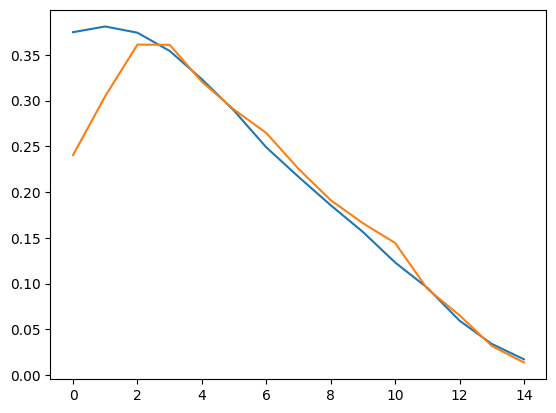

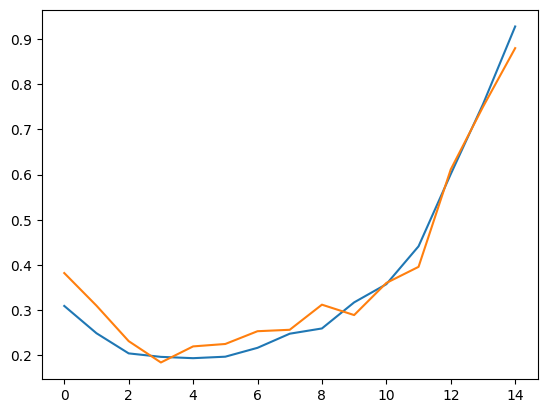

In [17]:
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
EPOCHS = 15
train_loss = []
val_loss = []
train_f1 = []
val_f1 = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_f1 = 0
    counter =0
    for batch in tqdm(train_dataloader):
        
        inputs = {key: value.to('cuda') for key, value in batch.items() if (key != 'labels' and key != 'tokens')}
        outputs = model(**inputs)
        
        probs = torch.nn.functional.softmax(outputs.logits, dim=2)
        
        coded_pred = torch.argmax(probs, dim=2)

        loss = criterion(outputs.logits.view(-1, 3), batch['labels'].to('cuda').view(-1))
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        tokens_batched = []
        
        for ids in batch['input_ids']:
            decoded = tokenizer.decode(ids.tolist(), skip_special_tokens=True)
            tokens_batched.append(decoded.split())

        # print(coded_pred.shape)
        # print(batch['labels'].shape)
        # raise ConnectionAbortedError
    
        tokens_gt_batched = []
        for batch_idx, sample in enumerate(batch['labels']):
            sample_gt = []
            for idx, class_t in enumerate(sample[1:len(tokens_batched[batch_idx])+1]):
                if class_t != 0:
                    sample_gt.append(tokens_batched[batch_idx][idx])
            tokens_gt_batched.append(sample_gt)
        
        tokens_pred_batched = []
        for batch_idx, sample in enumerate(coded_pred):
            sample_pred = []
            for idx, class_t in enumerate(sample[1:len(tokens_batched[batch_idx])+1]):
                if class_t != 0:
                    sample_pred.append(tokens_batched[batch_idx][idx])
            tokens_pred_batched.append(sample_pred)

        # for batch_num in range(TRAIN_BATCH_SIZE):
        #     max_num_tok = len(tokens_gt_batched[batch_num])
        #     if len(tokens_pred_batched[batch_num]) > max_num_tok:
        #         for _ in range(len(tokens_pred_batched[batch_num]) - max_num_tok):
        #             tokens_gt_batched[batch_num].append('')
        #     else:
        #         for _ in range(max_num_tok - len(tokens_pred_batched[batch_num])):
        #             tokens_pred_batched[batch_num].append('')
        
        
        f1 = comp_metric(tokens_gt_batched, tokens_pred_batched)
        total_f1 += f1

        optimizer.step()
        # if counter % 100 == 0:
        # print(f'F1: {f1}, loss: {loss}')
        # counter += 1
        # if counter == 10:
        #     raise ConnectionAbortedError
        # scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_f1 = total_f1 / len(train_dataloader)
    train_loss.append(avg_train_loss)
    train_f1.append(avg_train_f1)
    print(f"Train loss: {avg_train_loss}, train f1: {avg_train_f1}")
    
    model.eval()
    total_val_loss = 0
    total_val_f1 = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs = {key: value.to('cuda') for key, value in batch.items() if key != 'labels'}
            outputs = model(**inputs, labels=batch['labels'].to('cuda'))

            probs = torch.nn.functional.softmax(outputs.logits, dim=2)
        
            coded_pred = torch.argmax(probs, dim=2)
            torch.nn.utils.clip_grad_value_(model.parameters(), 10)
            loss = criterion(outputs.logits.view(-1, 3), batch['labels'].to('cuda').view(-1))
            total_val_loss += loss.item()

            tokens_batched = []
            
            for ids in batch['input_ids']:
                decoded = tokenizer.decode(ids.tolist(), skip_special_tokens=True)
                tokens_batched.append(decoded.split())

            tokens_gt_batched = []
            for batch_idx, sample in enumerate(batch['labels']):
                sample_gt = []
                for idx, class_t in enumerate(sample[1:len(tokens_batched[batch_idx])+1]):
                    if class_t != 0:
                        sample_gt.append(tokens_batched[batch_idx][idx])
                tokens_gt_batched.append(sample_gt)
            
            tokens_pred_batched = []
            for batch_idx, sample in enumerate(coded_pred):
                sample_pred = []
                for idx, class_t in enumerate(sample[1:len(tokens_batched[batch_idx])+1]):
                    if class_t != 0:
                        sample_pred.append(tokens_batched[batch_idx][idx])
                tokens_pred_batched.append(sample_pred)

            # for batch_num in range(TRAIN_BATCH_SIZE):
            #     max_num_tok = len(tokens_gt_batched[batch_num])
            #     if len(tokens_pred_batched[batch_num]) > max_num_tok:
            #         for _ in range(len(tokens_pred_batched[batch_num]) - max_num_tok):
            #             tokens_gt_batched[batch_num].append('')
            #     else:
            #         for _ in range(max_num_tok - len(tokens_pred_batched[batch_num])):
            #             tokens_pred_batched[batch_num].append('')
            
            
            f1 = comp_metric(tokens_gt_batched, tokens_pred_batched)
            total_val_f1 += f1

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_f1 = total_val_f1 / len(val_dataloader)
    val_loss.append(avg_val_loss)
    val_f1.append(avg_val_f1)
    print(f"Val loss: {avg_val_loss}, val f1: {avg_val_f1}")
    
plt.figure()
sns.lineplot(train_loss)
sns.lineplot(val_loss)
plt.savefig('Losses_ru.png')

plt.figure()
sns.lineplot(train_f1)
sns.lineplot(val_f1)
plt.savefig('f1_ru.png')

torch.save(model, 'ru_300k_last.pth')
torch.save(model.state_dict(), 'ru_weights_300k_last.pth')
torch.save(tokenizer, 'ru_tokenizer_300k_last.pth')